## Install Prophet


In [11]:
%pip install prophet

## Import Libraries

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf # Import data directly from Yahoo Finance
from prophet import Prophet

## Download the Data

In [13]:
stock = "AAPL"  # AAPL stock

# Download the last 60 days of hourly close prices
df = yf.download(
    stock,
    period="60d",
    interval="60m",
    auto_adjust=True,
    progress=False,
)

df = df[["Close"]].copy()
df.tail()

Price,Close
Ticker,AAPL
Datetime,
2025-09-26 15:30:00+00:00,255.664993
2025-09-26 16:30:00+00:00,256.519989
2025-09-26 17:30:00+00:00,256.554993
2025-09-26 18:30:00+00:00,255.645004
2025-09-26 19:30:00+00:00,255.460007


In [14]:
# Check if the index has a timezone, if not, localise to UTC
if df.index.tz is None:
    df.index = df.index.tz_localize("UTC")

# Convert to Malaysia timezone
df.index = df.index.tz_convert("Asia/Kuala_Lumpur")

# Ensure hourly frequency and forward-fill missing values
close = df["Close"].asfreq("H").ffill()
close.tail()

/tmp/ipython-input-1138469034.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  close = df["Close"].asfreq("H").ffill()


Ticker,AAPL
Datetime,
2025-09-26 23:30:00+08:00,255.664993
2025-09-27 00:30:00+08:00,256.519989
2025-09-27 01:30:00+08:00,256.554993
2025-09-27 02:30:00+08:00,255.645004
2025-09-27 03:30:00+08:00,255.460007


## Prepare data


In [15]:
prophet_df = close.copy()
prophet_df.index.name = 'ds'
prophet_df = prophet_df.rename(columns={'Close': 'y'})
display(prophet_df.head())

Ticker,AAPL
ds,
2025-07-03 21:30:00+08:00,213.735001
2025-07-03 22:30:00+08:00,213.880005
2025-07-03 23:30:00+08:00,214.100006
2025-07-04 00:30:00+08:00,214.100006
2025-07-04 01:30:00+08:00,214.100006


## Fit Prophet Model



In [16]:
prophet_df = close.copy()
prophet_df = prophet_df.reset_index()
prophet_df = prophet_df.rename(columns={'Datetime': 'ds', 'AAPL': 'y'})
prophet_df['ds'] = prophet_df['ds'].dt.tz_convert(None)

model = Prophet()
model.fit(prophet_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpudw_ut5_/m2zissn2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpudw_ut5_/gxwrnimd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6723', 'data', 'file=/tmp/tmpudw_ut5_/m2zissn2.json', 'init=/tmp/tmpudw_ut5_/gxwrnimd.json', 'output', 'file=/tmp/tmpudw_ut5_/prophet_modeliiq4m_qe/prophet_model-20250929041039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:10:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:10:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Create Future Dataframe



In [17]:
future = model.make_future_dataframe(periods=48, freq='h')
display(future.head())

,ds
0,2025-07-03 13:30:00
1,2025-07-03 14:30:00
2,2025-07-03 15:30:00
3,2025-07-03 16:30:00
4,2025-07-03 17:30:00


## Make Predictions



In [18]:
forecast_prophet = model.predict(future)
display(forecast_prophet.head())

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2025-07-03 13:30:00,214.961423,211.930832,217.049216,214.961423,214.961423,-0.344433,-0.344433,-0.344433,0.055452,0.055452,0.055452,-0.399885,-0.399885,-0.399885,0.0,0.0,0.0,214.616989
1,2025-07-03 14:30:00,214.932072,212.093517,217.346303,214.932072,214.932072,-0.224598,-0.224598,-0.224598,0.165961,0.165961,0.165961,-0.390559,-0.390559,-0.390559,0.0,0.0,0.0,214.707474
2,2025-07-03 15:30:00,214.902722,211.931947,217.399654,214.902722,214.902722,-0.178068,-0.178068,-0.178068,0.202523,0.202523,0.202523,-0.380591,-0.380591,-0.380591,0.0,0.0,0.0,214.724654
3,2025-07-03 16:30:00,214.873372,211.922397,217.096126,214.873372,214.873372,-0.197882,-0.197882,-0.197882,0.172060,0.172060,0.172060,-0.369942,-0.369942,-0.369942,0.0,0.0,0.0,214.675490
4,2025-07-03 17:30:00,214.844022,212.045568,217.405363,214.844022,214.844022,-0.237465,-0.237465,-0.237465,0.121108,0.121108,0.121108,-0.358573,-0.358573,-0.358573,0.0,0.0,0.0,214.606557


## Visualize results


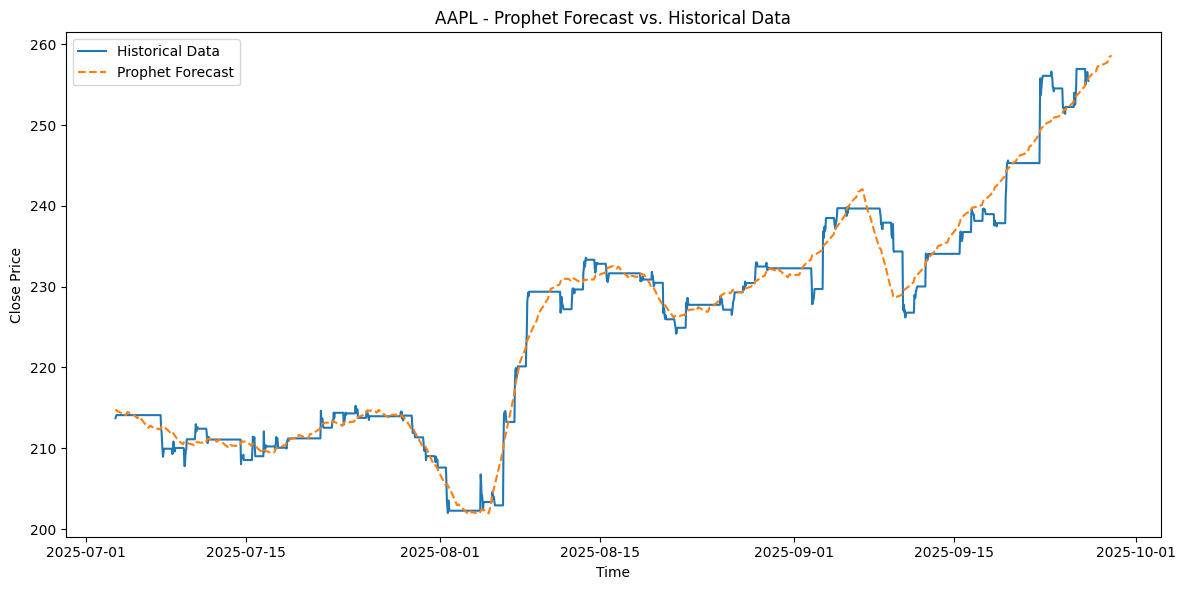

In [19]:
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(prophet_df['ds'], prophet_df['y'], label='Historical Data')

# Plot Prophet forecast
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Prophet Forecast', linestyle='--')

plt.title(f'{stock} - Prophet Forecast vs. Historical Data')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   The `prophet` library was successfully installed (or was already present) for time series forecasting.
*   The historical stock data was prepared in the required format for Prophet, with 'ds' for datetime and 'y' for the closing price.
*   A Prophet model was initialized and successfully fitted to the historical data.
*   A future dataframe with timestamps for the next 48 hours at an hourly frequency was created using the fitted model.
*   Forecasts for the future timestamps were successfully generated using the fitted Prophet model.
*   A visualization was created comparing the historical stock prices and the Prophet forecast, showing the historical data and the predicted values.

### Insights or Next Steps

*   Evaluate the accuracy of the Prophet forecast by comparing the predicted values against actual future stock prices once they become available.
*   Consider adding relevant regressors or holidays to the Prophet model to potentially improve forecasting accuracy.
